In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

# __The Lottery Hypothesis__ code implementation:
The following _Jupyter Notebook_ is the Pythonic implementation of __The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks__ paper by _Jonathan Frankle, Michael Carbin_.

The paper can be found in _arXiv:1803.03635_

__Identifying winning tickets:__
We identify a winning ticket by training a network and pruning its smallest-magnitude weights. The remaining, unpruned connections constitute the architecture of the winning ticket.

Unique to our work, each unpruned connection’s value is then reset to its initializationfrom original network _before_ it was trained. This forms our central experiment:

1. Randomly initialize a neural network f(x;θ0) (where θ0∼Dθ).
1. Train the network for _j_ iterations, arriving at parameters θj.
1. Prune p% of the parameters in θj, creating a mask _m_.
1. Reset the remaining parameters to their values in θ0, creating the winning ticketf(x;mθ0).
1. To evaluate whether the resulting network at step (4) is indeed a winning ticket, train the pruned, untrained network and examine its convergence behavior and accuracy.

As described, this pruning approach is __one-shot__:  the network is trained once, p% of weights are pruned,
and the surviving weights are reset.

However, in this paper, we focus on __iterative pruning__, which repeatedly trains, prunes, and resets the network over __n__ rounds; each round prunes (p1/n)% of the weights that survive the previous round.

Our results show that __iterative pruning__ finds winning tickets that match the accuracy of the original network at smaller sizes than does __one-shot__ pruning.

Frankle and Carbin found that running this process _iteratively_ produced the smallest winning tickets. That is, __the network found at step (4) becomes a new network to train and further prune again at steps (2) and (3)__.

By training, pruning, resetting, and repeating many times, Frankle and Carbin achieved their best results.


In [2]:
tf.__version__

'2.0.0'

In [3]:
batch_size = 32
num_classes = 10
epochs = 50

In [4]:
# Data preprocessing and cleadning:
# input image dimensions
img_rows, img_cols = 28, 28

# Load MNIST dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (28, 28, 1)



In [6]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [7]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
# Reshape training and testing sets-
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 784), y_train = (60000, 10)
X_test.shape = (10000, 784), y_test = (10000, 10)


In [10]:
l = tf.keras.layers

### Step - 1: Randomly initialize a Neural Network
Here, we choose the architecture for classification of MNIST dataset which is 300 100 densely conncected network and randomly initialize the weights/biases of the neural network, and also __save__ this random weights/biases initialization, which will be used later.

In [11]:
# The model is first trained without any pruning for 15 epochs-
epochs = 30

num_train_samples = X_train.shape[0]

end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  56250


### tfmot.sparsity.keras.PolynomialDecay
Pruning Schedule with a PolynomialDecay function.

Initializes a Pruning schedule with a PolynomialDecay function.

Pruning rate grows rapidly in the beginning from initial_sparsity, but then plateaus slowly to the target sparsity. The function applied is

current_sparsity = final_sparsity + (initial_sparsity - final_sparsity) * (1 - (step - begin_step)/(end_step - begin_step)) ^ exponent

which is a polynomial decay function.

Args:

1. initial_sparsity: Sparsity (%) at which pruning begins.
1. final_sparsity: Sparsity (%) at which pruning ends.
1. begin_step: Step at which to begin pruning.
1. end_step: Step at which to end pruning.
1. power: Exponent to be used in the sparsity function.
1. frequency: Only apply pruning every frequency steps.


In [12]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.0,
        begin_step = 0, end_step=0, frequency=100)
}

In [13]:
def pruned_nn(pruning_params):
    """
    Function to define the architecture of a neural network model
    following 300 100 architecture for MNIST dataset and using
    provided parameter which are used to prune the model.
    
    Input: 'pruning_params' Python 3 dictionary containing parameters which are used for pruning
    Output: Returns designed and compiled neural network model
    """
    
    pruned_model = Sequential()
    pruned_model.add(l.InputLayer(input_shape=(784, )))
    pruned_model.add(Flatten())
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 300, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.2))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = 100, activation='relu', kernel_initializer=tf.initializers.GlorotUniform()),
        **pruning_params))
    # pruned_model.add(l.Dropout(0.1))
    pruned_model.add(sparsity.prune_low_magnitude(
        Dense(units = num_classes, activation='softmax'),
        **pruning_params))
    
    # Compile pruned CNN-
    pruned_model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer=tf.keras.optimizers.Adam(lr = 0.001),
        metrics=['accuracy'])
    
    return pruned_model


In [14]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callbacks = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [15]:
# Instantiate NN-
orig_model = pruned_nn(pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


### Save randomly initialized weights BEFORE the model is:

1. trained
1. pruned
1. stripped of extra pruning parmeters from architecture of original neural network

In [16]:
# Save random initialized weights BEFORE pruning and training of NN
# and BEFORE the model is STRIPPED-
orig_model.save_weights("Weights/MNIST_300_100_Randomly_Initialized_weights.h5", overwrite=True)

In [17]:
# Strip the pruning wrappers from UNPRUNED model-
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [19]:
# Save random uninitialized weights BEFORE pruning of NN using STRIPPED model-
# orig_model_stripped.save_weights("MNIST_300_100_Original_Weights_Unpruned.h5", overwrite=True)

In [18]:
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 300)               470702    
_________________________________________________________________
prune_low_magnitude_dense_1  (None, 100)               60102     
_________________________________________________________________
prune_low_magnitude_dense_2  (None, 10)                2012      
Total params: 532,816
Trainable params: 266,610
Non-trainable params: 266,206
_________________________________________________________________


In [19]:
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### Step - 2: Train the (unpruned) Neural Network until it converges
_Early Stopping_ criterion has been used for training of the model

In [20]:
# Train unpruned Neural Network-
history_orig = orig_model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 179us/sample - loss: 0.2032 - accuracy: 0.9399 - val_loss: 0.1195 - val_accuracy: 0.9626
Epoch 2/30
60000/60000 [==============================] - 9s 155us/sample - loss: 0.0852 - accuracy: 0.9732 - val_loss: 0.0891 - val_accuracy: 0.9712
Epoch 3/30
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0552 - accuracy: 0.9830 - val_loss: 0.0897 - val_accuracy: 0.9723
Epoch 4/30
60000/60000 [==============================] - 9s 153us/sample - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.0746 - val_accuracy: 0.9794
Epoch 5/30
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0787 - val_accuracy: 0.9774
Epoch 6/30
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0736 - val_accuracy: 0.9782
Epoch 7/30
60000/60000 [=========================

In [26]:
# Get the last 3 'val_loss'-
history_orig.history['val_loss'][-3:]

[0.08566837142373625, 0.08082119292882962, 0.10430033170154183]

In [27]:
# Evaluate priginal unpruned trained model on testing dataset-
score_orig_model = orig_model.evaluate(X_test, y_test, verbose=0)

print("\nOriginal & UNPRUNED model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_orig_model[0], score_orig_model[1]))


Original & UNPRUNED model metrics on testing dataset:
loss = 0.1043 and accuracy = 0.9768



In [28]:
# Train parameters of neural network AFTER training UNPRUNED model-
orig_model.save_weights("Weights/MNIST_300_100_Trained_Weights_Unpruned.h5", overwrite = True)

In [29]:
history_orig.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

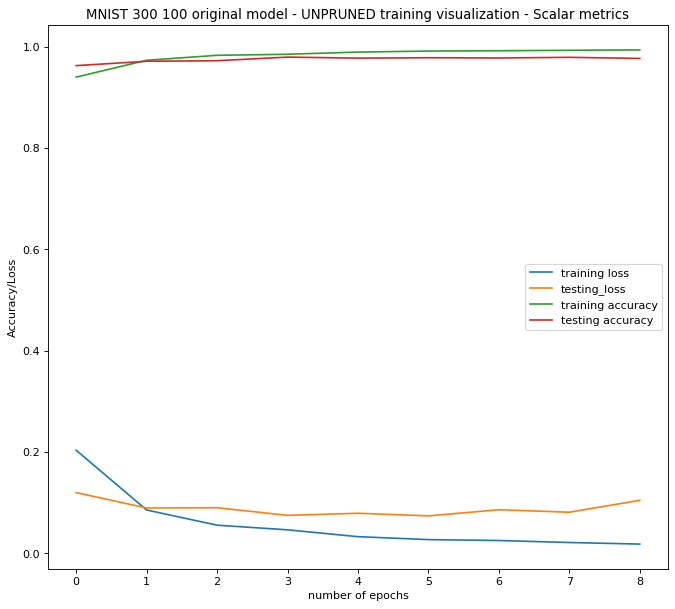

In [30]:
# Visualize the training of the neural network (scalar metrics):
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing_loss')
plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST 300 100 original model - UNPRUNED training visualization - Scalar metrics")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy/Loss")
plt.legend(loc = 'best')  # 'center right'
plt.show()


### Count number of non-zero parameters in each layer-

In [31]:
print("\nIn original unpruned model, number of nonzero parameters in each layer are: \n")

orig_sum_params = 0

for layer in orig_model.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    orig_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(orig_sum_params))


In original unpruned model, number of nonzero parameters in each layer are: 

235200
300
30000
100
1000
10

Total number of trainable parameters = 266610



In [32]:
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### OBSERVATION:

From the above codes, we can see that, using no pruning, the number of parameters remain the same!

**Step - 3: Neural Network Pruning [Prune p% of the NN]** using __One-Shot pruning__

**We are using _One-Shot pruning_ here**

In __One-Shot pruning__, the process used is as follows:

1. The neural network is trained once p% of the weights are pruned

1. The remaining (100 - p)% of the weights are reset to the _original_ weights __before__ the training & pruning of the neural network began.

1. To evaluate whether the resulting network at step (2) is indeed a winning ticket, train the pruned, untrained network and examine its convergence behavior and accuracy.


In [33]:
# Specify the parameters to be used for layer-wise pruning
# Now, the model will be pruned off with 78.9% of its weights-
pruning_params_pruned = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity = 0.0, final_sparsity = 0.789,
        begin_step = 0, end_step = end_step,
        frequency=100)
}

# NOTE:
# Here, p = 78.9%

In [34]:
# Instantiate a Nueal Network model to be pruned using parameters from above-
pruned_model = pruned_nn(pruning_params_pruned)

In [35]:
# Load weights from original trained and unpruned model-
pruned_model.load_weights("Weights/MNIST_300_100_Trained_Weights_Unpruned.h5")

In [36]:
# Train pruned CNN-
history_pruned = pruned_model.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 185us/sample - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.0811 - val_accuracy: 0.9800
Epoch 2/30
60000/60000 [==============================] - 10s 167us/sample - loss: 0.0095 - accuracy: 0.9968 - val_loss: 0.1261 - val_accuracy: 0.9754
Epoch 3/30
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0973 - val_accuracy: 0.9809
Epoch 4/30
60000/60000 [==============================] - 10s 166us/sample - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.0973 - val_accuracy: 0.9818


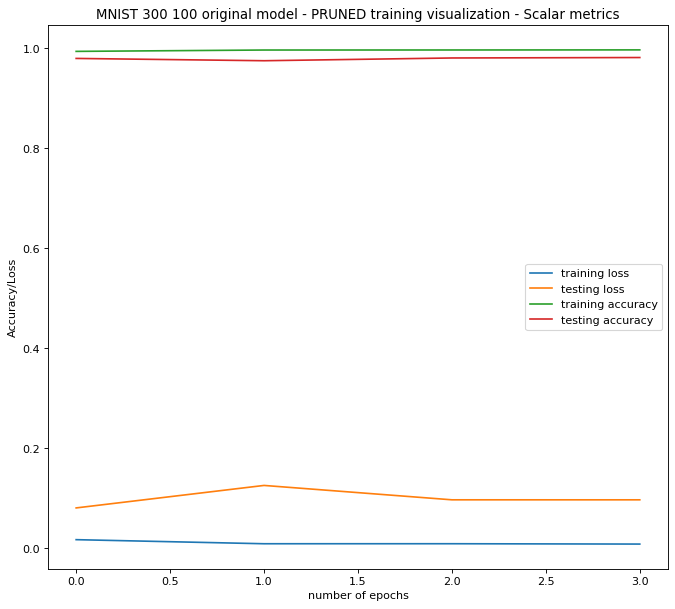

In [37]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_pruned.history['loss'], label = 'training loss')
plt.plot(history_pruned.history['val_loss'], label = 'testing loss')
plt.plot(history_pruned.history['accuracy'], label = 'training accuracy')
plt.plot(history_pruned.history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST 300 100 original model - PRUNED training visualization - Scalar metrics")
plt.ylabel("Accuracy/Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

In [38]:
# Evaluate pruned trained model on testing dataset-
score_pruned_model = pruned_model.evaluate(X_test, y_test, verbose = 0)

print("\nPRUNED model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_pruned_model[0], score_pruned_model[1]))


PRUNED model metrics on testing dataset:
loss = 0.0973 and accuracy = 0.9818



In [39]:
# Save weights of PRUNED and Trained model BEFORE stripping-
pruned_model.save_weights("Weights/MNIST_300_100_Weights_Pruned_with_pruning_params.h5", overwrite = True)

In [40]:
# Strip the pruning wrappers from pruned model-
pruned_model_stripped = sparsity.strip_pruning(pruned_model)

In [41]:
# Show architecture of model (with pruning parameters)-
pruned_model_stripped.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [42]:
print("\nIn original unpruned model, number of nonzero parameters in each layer are: \n")

orig_sum_params = 0

for layer in orig_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    orig_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(orig_sum_params))


In original unpruned model, number of nonzero parameters in each layer are: 

235200
300
30000
100
1000
10

Total number of trainable parameters = 266610



In [43]:
print("\nIn pruned model, number of nonzero parameters in each layer are: \n")

pruned_sum_params = 0

for layer in pruned_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(pruned_sum_params))


In pruned model, number of nonzero parameters in each layer are: 

171173
300
21833
100
728
10

Total number of trainable parameters = 194144



In [44]:
# Sanity-check: confirm that p = 30% of the weights are actually pruned away from the network-
print("\n% of weights pruned away = {0:.2f}%\n".format( \
    (orig_sum_params - pruned_sum_params) / orig_sum_params * 100))


% of weights pruned away = 27.18%



### Step - 3: Create mask for maintaining the sparsity of winning tickets:
Prune _p_% of the parameters in theta_j, creating a mask _m_

The mask is created as follows-
1. Weights surviving the pruning are initialized to one (1)
1. Weights which are pruned are initialized to zero (0)

In [45]:
# Instantiate a new neural network model for which, the mask is to be created,
# according to the paper-
mask_model = pruned_nn(pruning_params_unpruned)

In [47]:
# Load weights of PRUNED model-
mask_model.load_weights("Weights/MNIST_300_100_Weights_Pruned_with_pruning_params.h5")

In [48]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [49]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [50]:
print("\nNetwork architecture of masked model:\n")

for layer in mask_model_stripped.trainable_weights:
    print(layer.shape)


Network architecture of masked model:

(784, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [51]:
# Sanity check whether mask is indeed created-
mask_model_stripped.trainable_weights[2]

<tf.Variable 'prune_low_magnitude_dense_7/kernel:0' shape=(300, 100) dtype=float32, numpy=
array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.]], dtype=float32)>

In [52]:
print("\nMask model metrics:")
print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

masked_sum_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))


Mask model metrics:
layer-wise manner model, number of nonzero parameters in each layer are: 

171173
300
21833
100
728
10

Total number of trainable parameters = 194144



In [53]:
print("% of weights reduced = {0:.2f}%\n".format(((orig_sum_params - masked_sum_params) / orig_sum_params) * 100))

% of weights reduced = 27.18%



## Step - 4: Extracting the winning ticket (smaller subnetwork)
Reset the remaining parameters in the _pruned_ model to their values in from _Step - 1_ , creating the winning ticket (or, sub network)

In order to extract the winning ticket from the pruned neural network, __reset__ the weights of the surviving parts of the _pruned_ neural network to their _original randomly initialized and unpruned_ weights which were received before the training of the neural network model began (from above)

In [54]:
# Instantiate a new neural network model for which, the weights are to be extracted, according to the paper-
# wts_extracted_model = pruned_nn(pruning_params_unpruned)
winning_ticket_model = pruned_nn(pruning_params_unpruned)

In [55]:
# Load weights of PRUNED model-
# wts_extracted_model.load_weights("Weights/MNIST_300_100_Weights_Pruned_with_pruning_params.h5")
winning_ticket_model.load_weights("Weights/MNIST_300_100_Weights_Pruned_with_pruning_params.h5")

In [56]:
# Strip the model of its pruning parameters-
# wts_extracted_model_stripped = sparsity.strip_pruning(wts_extracted_model)
winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

## Extract winning ticket (sub network) for One-Shot pruning

In [57]:
# For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
# reinitialize it to the value, the model received BEFORE it was trained and pruned-

'''
for orig_wts, winning_wts in zip(orig_model_stripped.trainable_weights, winning_ticket_model_stripped.trainable_weights):
    winning_wts = tf.where(tf.equal(wts_extracted, 0), wts_extracted, orig_wts)
'''

for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights, winning_ticket_model_stripped.trainable_weights):
    pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))

In [58]:
# Sanity check-
winning_ticket_model_stripped.trainable_weights[2]

<tf.Variable 'prune_low_magnitude_dense_10/kernel:0' shape=(300, 100) dtype=float32, numpy=
array([[-0.11160038, -0.07539377, -0.2546119 , ..., -0.        ,
        -0.09774541, -0.18739353],
       [-0.23822643,  0.        , -0.08943658, ..., -0.2151377 ,
         0.21154119, -0.17619933],
       [-0.1032735 , -0.14900354, -0.29805177, ..., -0.21281539,
        -0.05728073,  0.18085186],
       ...,
       [-0.19137503, -0.169748  ,  0.20753136, ...,  0.14428455,
         0.1664877 , -0.03382457],
       [-0.12591612,  0.08717755,  0.08691725, ...,  0.24557093,
         0.09970653,  0.07323103],
       [-0.        ,  0.        ,  0.07275223, ..., -0.190188  ,
         0.12115245, -0.16604216]], dtype=float32)>

In [59]:
print("\nWinning ticket, metrics:")
print("In winning ticket model: layer-wise manner model, number of nonzero parameters in each layer are: \n")

wts_extracted_sum_params = 0

for layer in winning_ticket_model_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    wts_extracted_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal number of trainable parameters = {0}\n".format(wts_extracted_sum_params))


Winning ticket, metrics:
In winning ticket model: layer-wise manner model, number of nonzero parameters in each layer are: 

171173
300
21833
100
728
10

Total number of trainable parameters = 194144



In [60]:
# Sanity check:
if wts_extracted_sum_params != pruned_sum_params:
    print("\nCritical Error! Number of parameters of winning ticket and pruned parameters do not match!\n")

In [62]:
# Save the weights (with pruning parameters) extracted to a file-
# wts_extracted_model.save_weights("MNIST_300_100_Weights_Extracted.h5", overwrite = True)
winning_ticket_model_stripped.save_weights("Weights/MNIST_300_100_Winning_Ticket_One_Shot.h5", overwrite=True)

### Step - 5: Evaluate resulting Neural Network model-
To evaluate the resulting Neural Network due to weights extraction above from _Step 4_, train the _pruned_ but _untrained_ Neural Network and observe it's convergence behavior in terms-

1. number of epochs (it takes to converge)
1. accuracy (as compared to original, unpruned model)

## Using _GradientTape_ API:

### Train _winning ticket_ model to observe it's convergence

In [99]:
# Instantiate a model-
model_gt = pruned_nn(pruning_params_unpruned)

In [100]:
# Strip model of pruning parameters-
model_gt_stripped = sparsity.strip_pruning(model_gt)

In [101]:
# Load weights of winning ticket-
model_gt_stripped.load_weights("Weights/MNIST_300_100_Winning_Ticket_One_Shot.h5")

In [ ]:
model_gt.summary()

In [ ]:
model_gt_stripped.summary()

In [102]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [103]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [104]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [105]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr = 0.001)

In [92]:
# Make predictions using sparse, stripped and trained model
# according to 'one-shot' approach-
model_gt_stripped(X_train).shape

TensorShape([60000, 10])

In [106]:
# compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# compute_accuracy = tf.keras.metrics.CategoricalAccuracy()

# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name = 'train_accuracy')

### Magic should happen here:

In [112]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    def train_step(data, labels):
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    '''
    for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
        # orig_grads.assign(tf.math.multiply(orig_grads, mask))
        orig_grads = tf.math.multiply(orig_grads, mask)
    '''
    
    # THIS IS CORRECT-
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    # return model_loss
    # return None


In [108]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


### Provide parameters for _EarlyStopping_

In [109]:
# User input-
minimum_delta = 0.001
patience = 3

patience_val = np.zeros(patience)

In [110]:
# Dictionary to hold scalar metrics-
history = {}

history['accuracy'] = np.zeros(epochs)
history['val_accuracy'] = np.zeros(epochs)
history['loss'] = np.zeros(epochs)
history['val_loss'] = np.zeros(epochs)

In [113]:
for epoch in range(epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_dataset:
        # train_step(x, y)
        train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
        # train_one_step(model_gt_stripped, optimizer, x, y)

    for x_t, y_t in test_dataset:
        # test_step(x_t, y_t)
        test_step(model_gt_stripped, optimizer, x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history['accuracy'][epoch] = train_accuracy.result()
    history['loss'][epoch] = train_loss.result()
    history['val_loss'][epoch] = test_loss.result()
    history['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))
    
    # Count number of non-zero parameters in each layer and in total-
    # print("layer-wise manner model, number of nonzero parameters in each layer are: \n")

    model_sum_params = 0
    
    for layer in model_gt_stripped.trainable_weights:
        # print(tf.math.count_nonzero(layer, axis = None).numpy())
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))


    if epoch > 2:
        # print("history['val_loss'][epoch - patience:epoch] = {0}".format(history['val_loss'][epoch - patience:epoch]))
        
        # Computes absolute differences between 3 consecutive loss values-
        differences = np.abs(np.diff(history['val_loss'][epoch - patience:epoch], n = 1))
        # print("differences: {0}".format(differences))
        
        # Checks whether the absolute differences is greater than 'minimum_delta'-
        check =  differences > minimum_delta
        # print("check = {0}\n".format(check))
        
        if np.all(check == False):
            print("\n\nEarlyStopping Evoked! Stopping training\n\n")
            break


Epoch 1, Loss: 0.0091, Accuracy: 99.9325, Test Loss: 0.0905, Test Accuracy: 99.624977
Total number of trainable parameters = 194144

Epoch 2, Loss: 0.0081, Accuracy: 99.9473, Test Loss: 0.1192, Test Accuracy: 99.536934
Total number of trainable parameters = 194144

Epoch 3, Loss: 0.0064, Accuracy: 99.9528, Test Loss: 0.1066, Test Accuracy: 99.622955
Total number of trainable parameters = 194144

Epoch 4, Loss: 0.0074, Accuracy: 99.9516, Test Loss: 0.0942, Test Accuracy: 99.625938
Total number of trainable parameters = 194144

Epoch 5, Loss: 0.0068, Accuracy: 99.9591, Test Loss: 0.1017, Test Accuracy: 99.615952
Total number of trainable parameters = 194144

Epoch 6, Loss: 0.0061, Accuracy: 99.9639, Test Loss: 0.1115, Test Accuracy: 99.608955
Total number of trainable parameters = 194144

Epoch 7, Loss: 0.0061, Accuracy: 99.9636, Test Loss: 0.1083, Test Accuracy: 99.632957
Total number of trainable parameters = 194144

Epoch 8, Loss: 0.0045, Accuracy: 99.9692, Test Loss: 0.1139, Test Acc

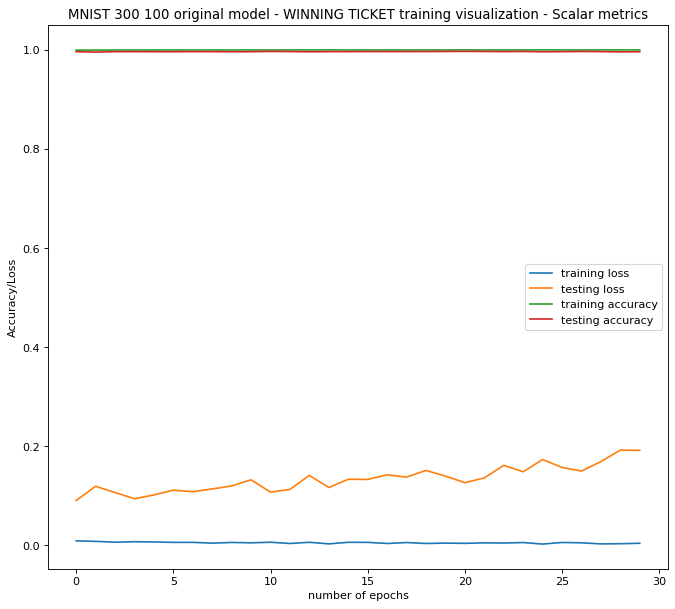

In [119]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['loss'], label = 'training loss')
plt.plot(history['val_loss'], label = 'testing loss')
plt.plot(history['accuracy'], label = 'training accuracy')
plt.plot(history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST 300 100 original model - WINNING TICKET training visualization - Scalar metrics")
plt.ylabel("Accuracy/Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

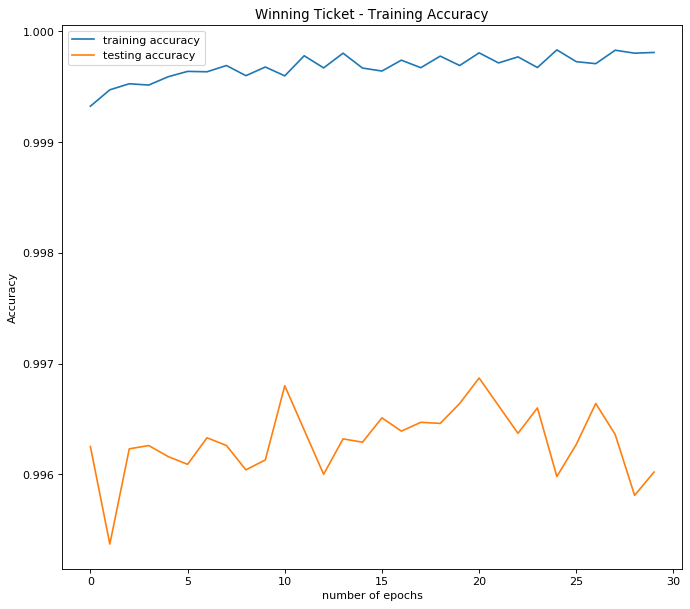

In [117]:
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['accuracy'], label = 'training accuracy')
plt.plot(history['val_accuracy'], label = 'testing accuracy')

plt.title("Winning Ticket - Training Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')
plt.show()

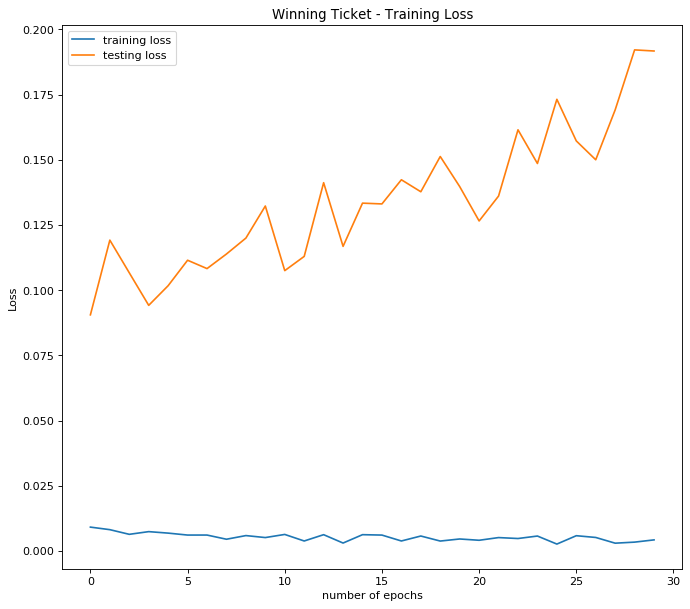

In [120]:
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history['loss'], label = 'training loss')
plt.plot(history['val_loss'], label = 'testing loss')

plt.title("Winning Ticket - Training Loss")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

In [121]:
print("\nWinning Ticket model metrics:")
print("number of non-zero weights in each layer:\n")

winning_tkt_wts_params = 0

for layer in model_gt_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    winning_tkt_wts_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal # of non-zero parameters in WINNING TICKET = {0}\n".format(winning_tkt_wts_params))


Winning Ticket model metrics:
number of non-zero weights in each layer:

171173
300
21833
100
728
10

Total # of non-zero parameters in WINNING TICKET = 194144



In [123]:
# Sanity check- number of parameters after training winning ticket and pruned parameters
# should be equal-
assert (winning_tkt_wts_params == pruned_sum_params), \
    "Parameters in winning ticket using masks are INCREASING! Critical Error!!"

In [126]:
# Save weights of Winning Ticket (One Shot) trained with GradientTape WITHOUT pruning parameters-
model_gt_stripped.save_weights("Weights/MNIST_300_100_Winning_Ticket_Trained_GradientTape.h5", overwrite=True)

In [144]:
# Save weights of Winning Ticket (One Shot) trained with GradientTape WITH pruning parameters-
model_gt.save_weights("Weights/MNIST_300_100_Winning_Ticket_Trained_GradientTape_Pruning_Parameters.h5", overwrite=True)

In [128]:
# GradientTape model WITH pruning parameters-
for layer in model_gt.trainable_variables:
    print(layer.shape)

(784, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [ ]:
model_gt.trainable_variables[4]

In [130]:
print("\nWinning Ticket model WITH PRUNING parameters metrics:")
print("number of non-zero weights in each layer:\n")

wt_pruning_params = 0

for layer in model_gt.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    wt_pruning_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal # of non-zero parameters = {0}\n".format(wt_pruning_params))


Winning Ticket model WITH PRUNING parameters metrics:
number of non-zero weights in each layer:

171173
300
21833
100
728
10

Total # of non-zero parameters = 194144



In [129]:
# GradientTape model WITHOUT pruning parameters-
for layer in model_gt_stripped.trainable_variables:
    print(layer.shape)

(784, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [ ]:
model_gt_stripped.trainable_variables[4]

In [131]:
print("\nWinning Ticket model WITH PRUNING parameters metrics:")
print("number of non-zero weights in each layer:\n")

wt_no_pruning_params = 0

for layer in model_gt_stripped.trainable_weights:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    wt_no_pruning_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal # of non-zero parameters = {0}\n".format(wt_no_pruning_params))


Winning Ticket model WITH PRUNING parameters metrics:
number of non-zero weights in each layer:

171173
300
21833
100
728
10

Total # of non-zero parameters = 194144



In [139]:
print("\nCheck whether weights between 'model_gt' and 'model_gt_stripped' for all layers are same:\n")

for winning_tkt, winning_tkt_pruned in zip(model_gt.trainable_variables, model_gt_stripped.trainable_variables):
    print(np.all(winning_tkt == winning_tkt_pruned))


Check whether weights between 'model_gt' and 'model_gt_stripped' for all layers are same:

True
True
True
True
True
True


In [140]:
# Check whether all weights in both models are same for 5th layer-
np.all(model_gt.trainable_variables[4] == model_gt_stripped.trainable_variables[4])

True

In [149]:
# Initialize a model to load saved weights of trained winning ticket-
winning_tkt_retrain = pruned_nn(pruning_params_pruned)

In [150]:
# Load weights of model trained using GradientTape WITH pruning parameters-
winning_tkt_retrain.load_weights("Weights/MNIST_300_100_Winning_Ticket_Trained_GradientTape_Pruning_Parameters.h5")

### Sanity Check:
Check whether number of parameters are _same_ between the winning ticket from above and loaded weights

In [152]:
print("\nWinning Ticket loaded for further pruning metrics:")
print("number of non-zero weights in each layer:\n")

wt_tkt_pruning_params = 0

for layer in winning_tkt_retrain_stripped.trainable_variables:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    wt_tkt_pruning_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal # of non-zero parameters = {0}\n".format(wt_tkt_pruning_params))


Winning Ticket loaded for further pruning metrics:
number of non-zero weights in each layer:

171173
300
21833
100
728
10

Total # of non-zero parameters = 194144



In [153]:
# Train pruned CNN-
history_pruned = winning_tkt_retrain.fit(
    x = X_train, y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    shuffle = True
)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 188us/sample - loss: 0.0103 - accuracy: 0.9979 - val_loss: 0.2210 - val_accuracy: 0.9782
Epoch 2/30
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.1806 - val_accuracy: 0.9818
Epoch 3/30
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.1819 - val_accuracy: 0.9818
Epoch 4/30
60000/60000 [==============================] - 10s 164us/sample - loss: 0.0056 - accuracy: 0.9984 - val_loss: 0.1861 - val_accuracy: 0.9811
Epoch 5/30
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.1836 - val_accuracy: 0.9826


In [156]:
# Evaluate pruned trained model on testing dataset-
score_winning_tkt_retrain = winning_tkt_retrain.evaluate(X_test, y_test, verbose = 0)

print("\nWinning Ticket retrained model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_winning_tkt_retrain[0],
                                                       score_winning_tkt_retrain[1]))


Winning Ticket retrained model metrics on testing dataset:
loss = 0.1836 and accuracy = 0.9826



In [157]:
# Strip pruning parameters-
winning_tkt_retrain_stripped = sparsity.strip_pruning(winning_tkt_retrain)

In [158]:
print("\nWinning Ticket retrained metrics:")
print("number of non-zero weights in each layer:\n")

wt_tkt_retrained_params = 0

for layer in winning_tkt_retrain_stripped.trainable_variables:
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    wt_tkt_retrained_params += tf.math.count_nonzero(layer, axis = None).numpy()

print("\nTotal # of non-zero parameters = {0}\n".format(wt_tkt_retrained_params))


Winning Ticket retrained metrics:
number of non-zero weights in each layer:

157535
300
20094
100
670
10

Total # of non-zero parameters = 178709



In [162]:
(wt_tkt_pruning_params - wt_tkt_retrained_params) / wt_tkt_pruning_params

0.07950284325037085

## Iterative-pruning over many rounds:
__one-shot__ pruning approach: the network is trained once, p% of weights are pruned, and the surviving weights are reset. However, in this paper, the focus is on __iterative pruning__, which repeatedly trains, prunes, and resets the network over __n__ rounds; each round prunes (p1/n)%of the weights that survive the previous round.
The paper's results show that _iterative pruning_ finds winning tickets that match the accuracy of the original unpruned network at smaller sizes than does one-shot pruning.

__The Lottery Ticket__ hypothesis showed best results when-

1. The pruning and weight reinitialization of the neural network process was _iteratively_ appled over __n__ rounds (as opposed to __One-Shot__ pruning)

1. Each of the __n__ rounds prunes (p 1/n)% of the weights that remain the survive round of pruning

_Example:_

1. Let p = 50%, so 50% of the weights are pruned away

1. Let n = 5 (number of pruning rounds = 5, followed by iterative trainings)

1. Now, each round prunes (p 1/n)% of the weights, or, in this example, each round prunes 10% of the weights. And, we have 5 such rounds

In [ ]:
iterative_model = pruned_nn()